### Time Series Analysis on Tea Production

#### Setting up the system

In [70]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [71]:
# importing the dataset

df = pd.read_csv('nvk_production.csv')
df.head()

,Date,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
0,30-Apr-1997,417935,94143.0,22.53,145.17,120.31,24.86,20.76
1,31-May-1997,510033,109461.0,21.46,150.33,129.36,20.97,21.70
2,30-Jun-1997,436533,97275.0,22.28,160.32,135.69,24.63,23.10
3,31-Jul-1997,475422,98949.0,20.81,158.19,131.57,26.62,22.70
4,31-Aug-1997,441680,97419.0,22.06,161.18,138.90,22.28,23.50


#### Data Exploration

In [72]:
df.describe()

,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,315.000000
mean,617772.202532,131543.454114,21.375538,481.917247,417.246835,64.670411,67.405111
std,124931.300808,24519.161723,0.784540,357.192608,308.193115,53.704538,49.662106
min,219222.000000,51224.000000,18.460000,145.170000,106.480000,14.570000,20.760000
25%,524681.500000,114618.375000,20.850000,204.255000,169.760000,30.412500,28.350000
50%,624874.500000,133316.500000,21.395000,445.945000,382.870000,50.285000,62.520000
75%,704669.250000,149862.500000,21.842500,653.697500,547.607500,76.792500,90.480000
max,874851.000000,187893.000000,23.730000,2184.430000,1763.450000,420.980000,302.250000


In [73]:
df.shape

(316, 8)

In [74]:
df.columns

Index(['Date', 'GREEN LEAF (Kg)', 'MADE TEA (Kg)', 'NETT OUT TURN',
       'NETT SALE AVERAGE (Rs)', 'LOW GROWN AVERAGE (Rs)', 'DIFFERENCE (Rs)',
       'BOUGHT LEAF RATE (Rs)'],
      dtype='object')

In [75]:
df.dtypes

Date                       object
GREEN LEAF (Kg)             int64
MADE TEA (Kg)             float64
NETT OUT TURN             float64
NETT SALE AVERAGE (Rs)    float64
LOW GROWN AVERAGE (Rs)    float64
DIFFERENCE (Rs)           float64
BOUGHT LEAF RATE (Rs)     float64
dtype: object

In [76]:
df.isnull().sum()

Date                      0
GREEN LEAF (Kg)           0
MADE TEA (Kg)             0
NETT OUT TURN             0
NETT SALE AVERAGE (Rs)    0
LOW GROWN AVERAGE (Rs)    0
DIFFERENCE (Rs)           0
BOUGHT LEAF RATE (Rs)     1
dtype: int64

#### Data Preprocessing

In [77]:
# handling missing values

df = df.dropna()
df.shape

(315, 8)

In [78]:
# preprocessing the date column

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df.asfreq('M')
df.head()

,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
Date,,,,,,,
1997-04-30,417935,94143.0,22.53,145.17,120.31,24.86,20.76
1997-05-31,510033,109461.0,21.46,150.33,129.36,20.97,21.70
1997-06-30,436533,97275.0,22.28,160.32,135.69,24.63,23.10
1997-07-31,475422,98949.0,20.81,158.19,131.57,26.62,22.70
1997-08-31,441680,97419.0,22.06,161.18,138.90,22.28,23.50


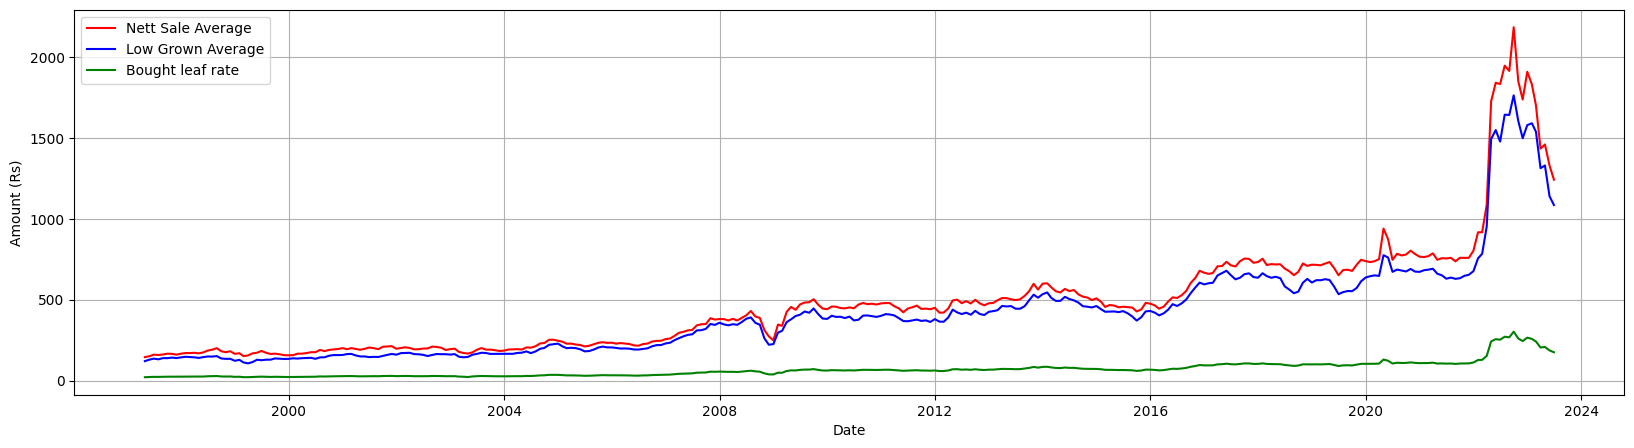

In [79]:
# plotting Nett Sale Average , Low grown average and Price paid per kg for externally purchased green leaf over time

plt.figure(figsize=(20,5))
plt.plot(df['NETT SALE AVERAGE (Rs)'],label = 'Nett Sale Average', color = 'red')
plt.plot(df['LOW GROWN AVERAGE (Rs)'],label = 'Low Grown Average', color = 'blue')
plt.plot(df['BOUGHT LEAF RATE (Rs)'],label = 'Bought leaf rate', color = 'green')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.legend(loc='best')
plt.grid()

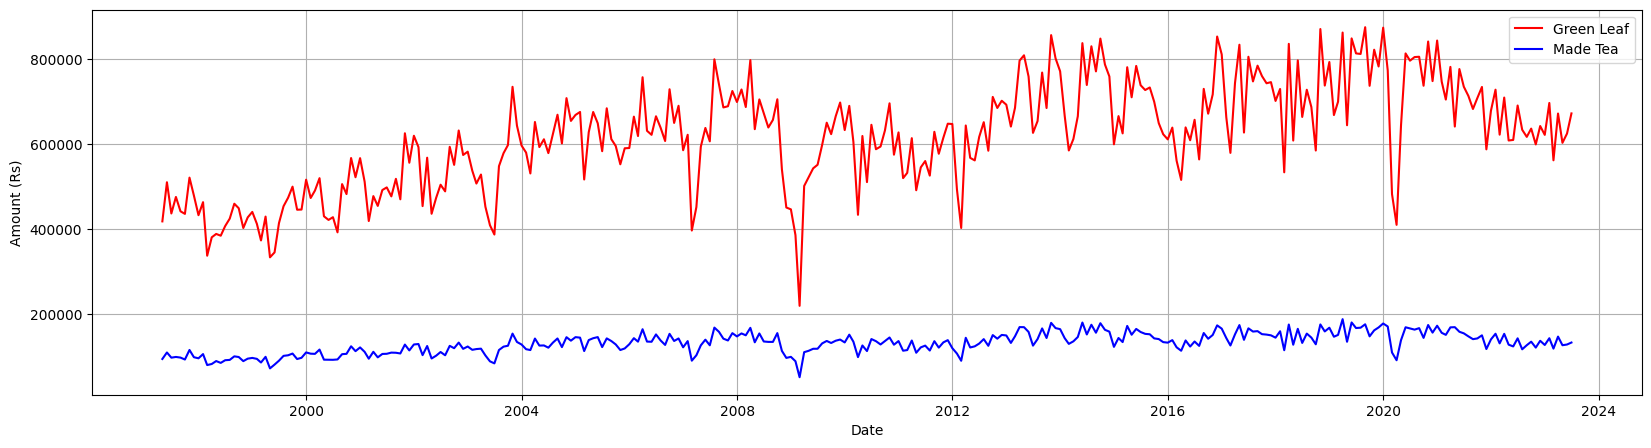

In [80]:
# plotting Green Leaf and Made Tea over time

plt.figure(figsize=(20,5))
plt.plot(df['GREEN LEAF (Kg)'],label = 'Green Leaf', color = 'red')
plt.plot(df['MADE TEA (Kg)'],label = 'Made Tea', color = 'blue')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.legend(loc='best')
plt.grid()

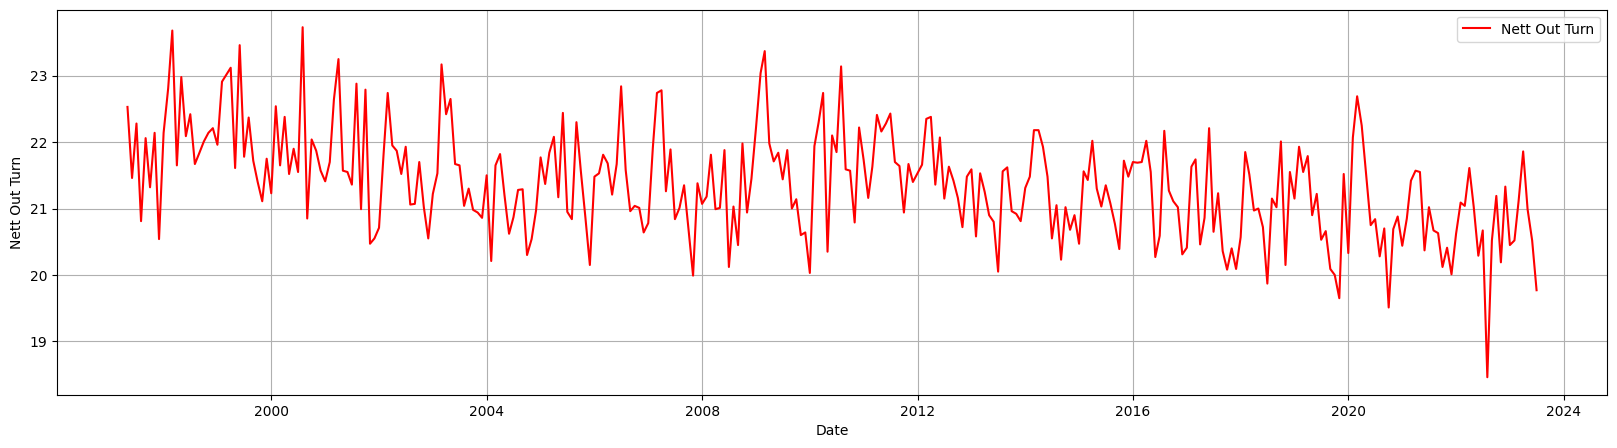

In [81]:
# plotting Nett Out Turn over time

plt.figure(figsize=(20,5))
plt.plot(df['NETT OUT TURN'],label = 'Nett Out Turn', color = 'red')
plt.xlabel('Date')
plt.ylabel('Nett Out Turn')
plt.legend(loc='best')
plt.grid()

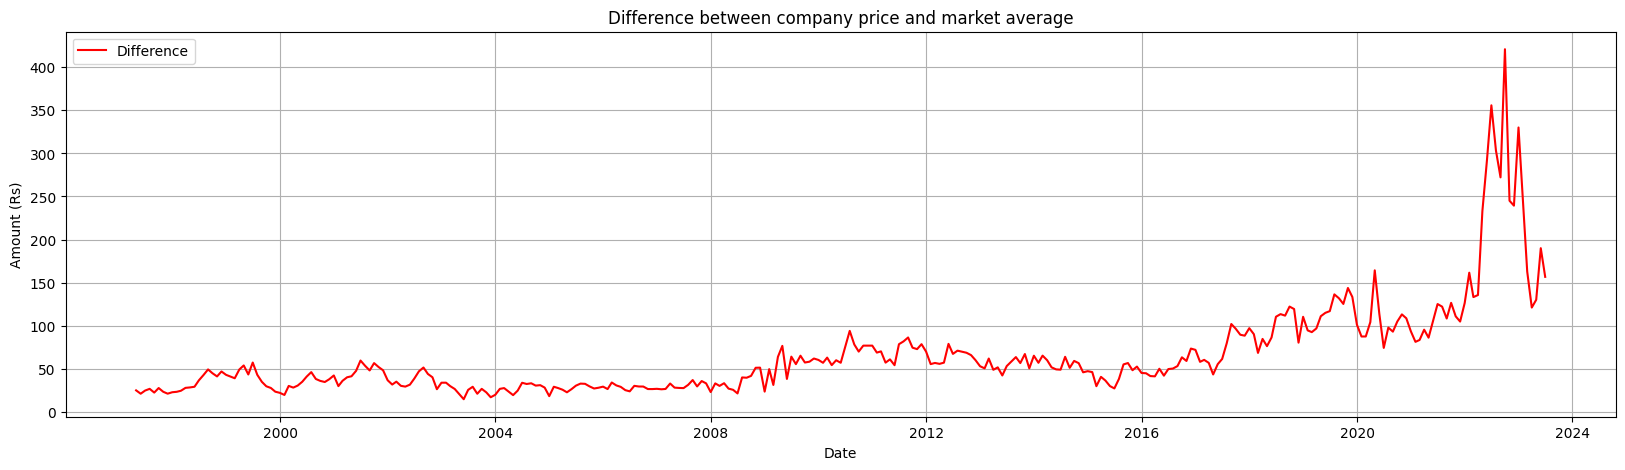

In [82]:
# plotting difference between company price and market average.

plt.figure(figsize=(20,5))
plt.plot(df['DIFFERENCE (Rs)'],label = 'Difference', color = 'red')
plt.xlabel('Date')
plt.ylabel('Amount (Rs)')
plt.title('Difference between company price and market average')
plt.legend(loc='best')
plt.grid()

#### Seasonality test

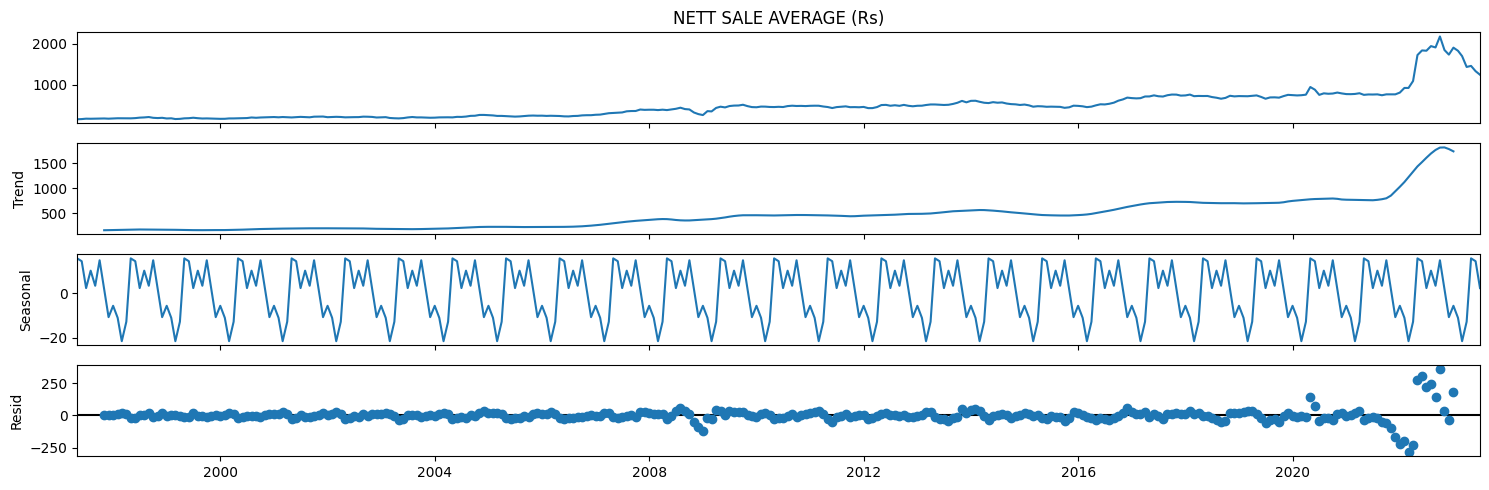

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

snl = seasonal_decompose(df['NETT SALE AVERAGE (Rs)'], model='additive', period=12)

# Create custom-sized plot
fig = snl.plot()
fig.set_size_inches(15, 5)
plt.tight_layout()
plt.show()

The timeseries has annual seasonality.

#### Stationarity

In [84]:
from statsmodels.tsa.stattools import adfuller

# function to test stationarity

def test_stationarity(timeseries):

    # determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # plotting rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries , label = 'Original', color = 'blue')
    plt.plot(rolmean, label = 'Rolling Mean', color = 'red')
    plt.plot(rolstd, label = 'Rolling Std', color = 'green')
    plt.xlabel('Date')
    plt.ylabel('Rolling Statistics')
    plt.title('Rolling Statistics',size = 15)
    plt.legend()
    plt.grid(True)
    plt.show()

    # dickey fuller test
    print('Results of Dickey Fuller test:\n')
    adf_test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adf_test[0:4],index = ['Test Statistics', 'p-value','No of lags used','No of Observations'])

    for key,value in adf_test[4].items():
        output['crtical value (%s)' %key] = value
    print(output)

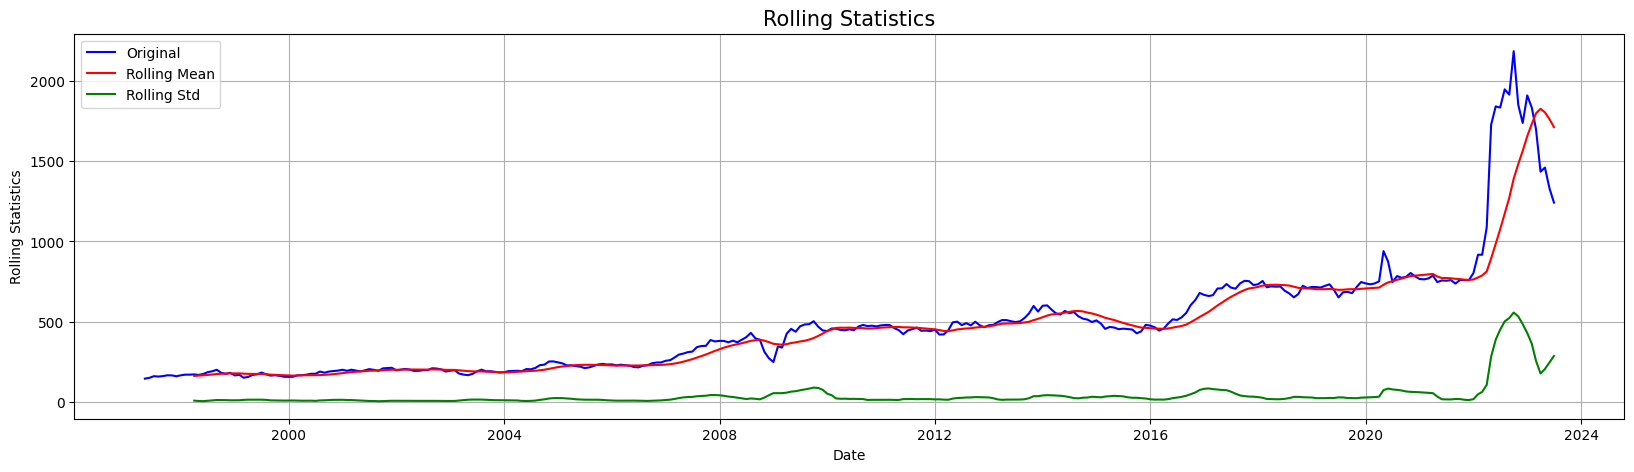

Results of Dickey Fuller test:

Test Statistics          1.742987
p-value                  0.998229
No of lags used         13.000000
No of Observations     301.000000
crtical value (1%)      -3.452263
crtical value (5%)      -2.871191
crtical value (10%)     -2.571912
dtype: float64


In [85]:
test_stationarity(df['NETT SALE AVERAGE (Rs)'])

p>0.05.Therefore,the timeseries is not stationary.

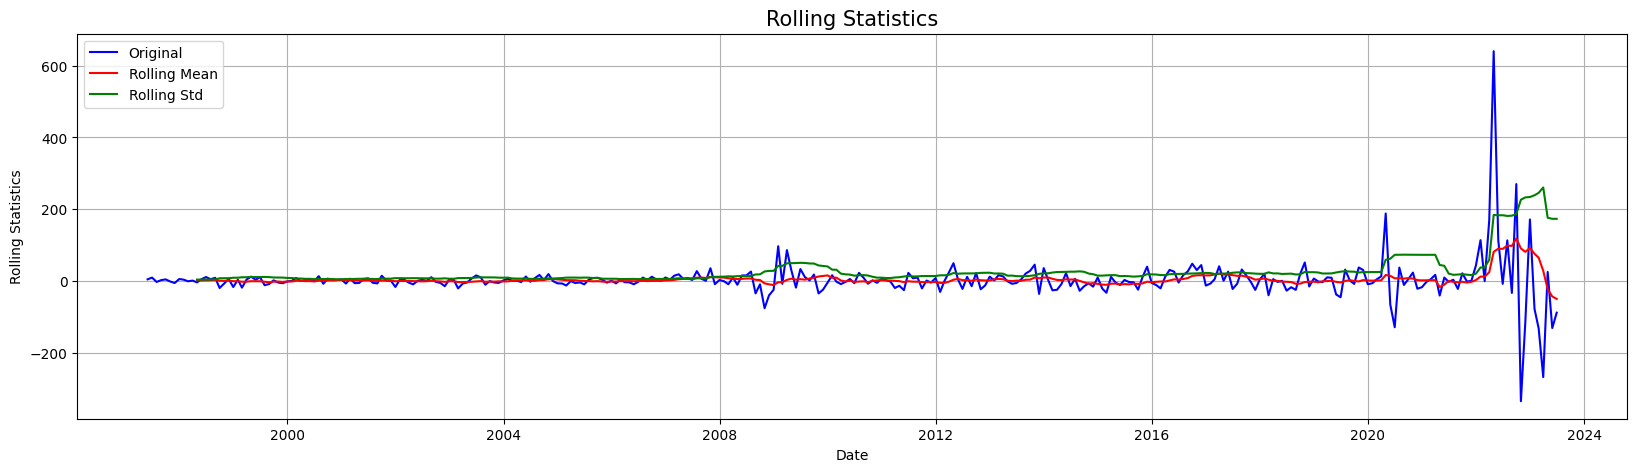

Results of Dickey Fuller test:

Test Statistics       -6.877287e+00
p-value                1.463559e-09
No of lags used        1.200000e+01
No of Observations     3.010000e+02
crtical value (1%)    -3.452263e+00
crtical value (5%)    -2.871191e+00
crtical value (10%)   -2.571912e+00
dtype: float64


In [86]:
# differencing
df_diff = df['NETT SALE AVERAGE (Rs)'].diff().dropna()
test_stationarity(df_diff)

p< 0.05. Therefore, the differenced timeseries is stationary

In [87]:
# splitting training and test data

train_size = int(len(df)*0.8)
test_size = int(len(df) - train_size)

df_train = df[:train_size]
df_test = df[train_size:]

#### Running Auto Arima with exogenous variables

In [88]:
df_train_exog = df_train[['LOW GROWN AVERAGE (Rs)','BOUGHT LEAF RATE (Rs)','DIFFERENCE (Rs)','NETT OUT TURN']]

In [90]:
# running auto arima

model = auto_arima(df_train['NETT SALE AVERAGE (Rs)'],
                   test='adf',
                   m = 12,
                   d=1,
                   seasonal=True,
                   stepwise=True,
                   trace=True,
                   exogenous = df_train_exog)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2165.598, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2163.618, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2165.305, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2165.540, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2165.708, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2165.162, Time=0.37 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2165.078, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2166.559, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2163.802, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2164.102, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2165.252, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 4.912 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      